In [159]:
%matplotlib inline
import pandas as pd
import glob
import datetime as dt
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
sns.set_context('notebook')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
data_folder = "data"
csvDataFiles = sorted(glob.glob(data_folder + "/*.csv"))
dataFiles = []
for dataFile in csvDataFiles:
    df = pd.read_csv(dataFile)
    dataFiles.append(df)

In [4]:
#The number of stocks we have in our data folder
print(len(dataFiles))

30


In [5]:
#This is what our data looks like
dataFiles[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/2/2017,154.259995,154.449997,152.720001,153.809998,152.636734,18698800
1,10/3/2017,154.009995,155.089996,153.910004,154.479996,153.301620,16230300
2,10/4/2017,153.630005,153.860001,152.460007,153.479996,152.309250,20163800
3,10/5/2017,154.179993,155.440002,154.050003,155.389999,154.204681,21283800
4,10/6/2017,154.970001,155.490005,154.559998,155.300003,154.115372,17407600


In [6]:
#The dimensions of the stock data
dataFiles[0].shape

(124, 7)

In [7]:
ratings_file = "Ratings.xlsx"
rating_df = pd.read_excel(ratings_file)
rating_cols = rating_df.columns.tolist()
rating_rows = rating_df.index.values.tolist()[1:] # skip first row
rating_rows

[('Buy', 5.0),
 ('Outperform', 4.0),
 ('Hold', 3.0),
 ('Underperform', 2.0),
 ('Sell', 1.0)]

In [8]:
rating_cols

['Current Rating', '1 Month Ago', '2 Months Ago', '3 Months Ago']

In [9]:
#Lets store the ratings in a form we can understand
ratings_folder = "Ratings"
xlsxRatingFiles = sorted(glob.glob(ratings_folder + "/*.xlsx"))
ratingsFiles = []
for ratingFile in xlsxRatingFiles:
    rf = pd.read_excel(ratingFile, names=rating_cols, index=False)
    ratingsFiles.append(rf)

In [10]:
#This is what our ratings look like
ratingsFiles[0].head()

,Current Rating,1 Month Ago,2 Months Ago,3 Months Ago
5,6,6,7,8
4,0,0,0,0
3,5,5,4,3
2,0,0,0,0
1,0,0,0,0


In [11]:
#The dimensions of the ratings data -- 5 rows and 4 columns
ratingsFiles[0].shape

(5, 4)

In [13]:
#  assume ratings come at the end of the month
# rows are ratings
# columns are months
# entries are number of analysts that gave a stock a having a certain rating during that month
# get stock ROI for each month for each stock

start3MonthsAgo = dt.datetime(2018, 1, 1)
end2MonthsAgo = dt.datetime(2018, 1, 31)

start2MonthsAgo = dt.datetime(2018, 2, 1)
end1MonthAgo = dt.datetime(2018, 2, 28)

start1MonthAgo = dt.datetime(2018, 3, 1)
end1MonthAgo = dt.datetime(2018, 3, 29)

In [15]:
allPriceDifs = []
for idx, dataFile in enumerate(dataFiles):
    # first select data from 3 months ago
    df = dataFile
    df['Date'] = pd.to_datetime(df['Date'])  
    threeMonthmask = (df['Date'] >= start3MonthsAgo) & (df['Date'] <= end2MonthsAgo)
    twoMonthmask = (df['Date'] >= start2MonthsAgo) & (df['Date'] <= end1MonthAgo)
    oneMonthmask = (df['Date'] >= start1MonthAgo) & (df['Date'] <= end1MonthAgo)
    dfLocList = [df.loc[threeMonthmask], df.loc[twoMonthmask], df.loc[oneMonthmask]]
    priceDifs = []
    for dfLoc in dfLocList:
        first_day = dfLoc.iloc[0]
        last_day  = dfLoc.iloc[-1]
        price_diff = last_day["Adj Close"] - first_day["Adj Close"]
        pct_dif = 100 * (price_diff / 2)
        priceDifs.append(pct_dif)
    allPriceDifs.append(priceDifs)

[-240.51894999999774, 34.06374999999997, -361.0000499999998]

In [17]:
priceDifs = pd.DataFrame(data=allPriceDifs, columns=["jan_pct_dif", "feb_pct_dif", "mar_pct_dif"])
priceDifs.head()

,jan_pct_dif,feb_pct_dif,mar_pct_dif
0,-240.51895,34.06375,-361.00005
1,40.39270,-336.00005,-93.00000
2,2862.37030,-1365.33355,-1090.49985
3,323.27655,-743.00000,-142.49955
4,148.38525,59.49990,-45.50000


In [30]:
# get the mean analyst rating for each stock
rating_labels = ['3 Months Ago', '2 Months Ago', '1 Month Ago']
ratings = []
for label in rating_labels:
    month_rating_list = []
    for f in ratingsFiles:
        df = f[label][f[label] > 0].to_frame()
        df['rating_val'] = df.index
        df["mult"] = df['rating_val'].multiply(df[label])
        rating_tot = df["mult"].sum()
        num_ratings = df[label].sum()
        
        mean_rating = rating_tot / num_ratings
        month_rating_list.append(mean_rating)
        
    ratings.append(month_rating_list)

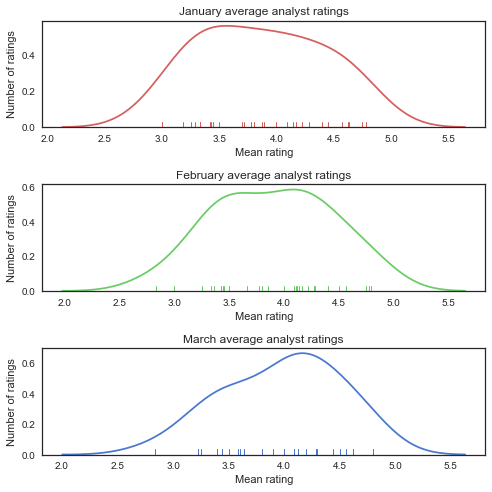

In [92]:
# let's plot the distribution of mean analyst ratings
month_names = ["January", "February", "March"]
colors = ["r", "g", "b"]
f, axes = plt.subplots(3, 1, figsize=(7, 7))
for i, (rating, month, color) in enumerate(zip(ratings, month_names, colors)):
    ax = sns.distplot(rating, hist=False, rug=True, ax=axes[i], color=color)
    ax.set(xlabel='Mean rating', ylabel='Number of ratings')
    ax.set_title(month + " average analyst ratings")
    
plt.tight_layout()
plt.show()

Text(0.5,1,'Monthly Stock Percent Price Differences')

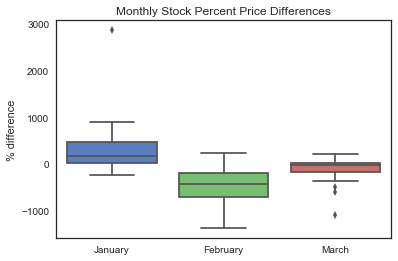

In [100]:
# now let's plot the monthly stock percent differences
ax = sns.boxplot(data=priceDifs.rename(index=str, columns={"jan_pct_dif": "January", 
                                                           "feb_pct_dif": "February", "mar_pct_dif": "March"}))

ax.set(ylabel='% difference')
ax.set_title("Monthly Stock Percent Price Differences")

In [105]:
# we use january and february mean analyst ratings as test data
X_train = pd.DataFrame(data=list(zip(ratings[0], ratings[1])), columns=["jan_mean_rating", "feb_mean_rating"])
# use january and february percent price difference as y training labels
y_train = priceDifs[["jan_pct_dif", "feb_pct_dif"]]
# use march for test data
X_test = pd.DataFrame(data=ratings[2], columns=["mar_mean_rating"])
y_test = priceDifs["mar_pct_dif"]
X_train.head()

,jan_mean_rating,feb_mean_rating
0,4.454545,4.272727
1,3.285714,3.500000
2,3.777778,3.777778
3,3.714286,3.857143
4,4.750000,4.750000


In [182]:
# we make a different model for each stock and test many different regressors. 
n, d = X_train.shape

models = [linear_model.BayesianRidge(), linear_model.ARDRegression(), linear_model.LinearRegression(),
         linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]), linear_model.Lasso(alpha = 0.1), linear_model.LassoLars(alpha=.1),
         linear_model.PassiveAggressiveRegressor(), linear_model.TheilSenRegressor(), linear_model.HuberRegressor()]
names = names = ["Bayesian Ridge", "ARD Regression", "Linear Regression", "Ridge CV",
         "Lasso", "Lasso Lars", "Passive Aggressive Regressor", "Theil-Sen Regressor", "Huber Regressor"]

accuracies = []
mae_list = []
for clf, name in zip(models, names):
    numTrue = 0
    tot_mae = 0
    for i in range(n):
        X_tr = X_train.iloc[i].reshape(-1, 1)
        y_tr = y_train.iloc[i].reshape(-1, 1)
        
        X_te = X_test.iloc[i].reshape(-1, 1)
        y_true = y_test.iloc[i].reshape(-1, 1)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        
        mae = mean_absolute_error(y_true, y_pred)  
        tot_mae += mae
        numTrue += 1 if (np.sign(y_true) == np.sign(y_pred)) else 0
        
    avg_mae = tot_mae / n
    acc = numTrue / n
    accuracies.append(acc)
    mae_list.append(avg_mae)
    print(name + ":")
    print("accuracy = %.2f, avg-MAE = %.2f" % (acc, avg_mae))
    print("")

Bayesian Ridge:
accuracy = 0.57, avg-MAE = 235.46

ARD Regression:
accuracy = 0.57, avg-MAE = 234.95

Linear Regression:
accuracy = 0.53, avg-MAE = 441.59

Ridge CV:
accuracy = 0.57, avg-MAE = 255.10

Lasso:
accuracy = 0.53, avg-MAE = 439.53

Lasso Lars:
accuracy = 0.53, avg-MAE = 441.46

Passive Aggressive Regressor:
accuracy = 0.30, avg-MAE = 170.19

Theil-Sen Regressor:
accuracy = 0.53, avg-MAE = 442.79

Huber Regressor:
accuracy = 0.53, avg-MAE = 340.15



Let's plot the results

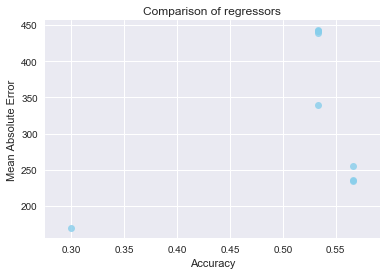

In [181]:
df=pd.DataFrame({'Accuracy': accuracies, 'Mean Absolute Error': mae_list, 'name': names })
ax = sns.regplot(x=df["Accuracy"], y=df["Mean Absolute Error"], fit_reg=False, color="skyblue")
plt.title("Comparison of regressors")
plt.show()
# we can see that the two Bayesian methods (Bayesian ridge regression and ARD regression) 
# achieve the lowest mean absolute error and accuracy